In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#cargamos los archivos
visits=pd.read_csv('/datasets/visits_log_us.csv')
orders=pd.read_csv('/datasets/orders_log_us.csv')
costs=pd.read_csv('/datasets/costs_us.csv')

In [3]:
#despues de revisados los archivos, renombramos las columnas para mayor eficiencia 
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']
costs.columns = ['source_id', 'dt', 'costs']

In [4]:
#hacemos la conversión de tipos de datos de las fechas
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [5]:
#corremos las verificaciones
visits.info()
costs.info()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entrie

In [6]:
#creamos las columnas con el período de la sesión (día, semana, mes)
visits['session_date'] = visits['start_ts'].dt.date
visits['session_month'] = visits['start_ts'].dt.to_period('M')
visits['session_week'] = visits['start_ts'].dt.to_period('W')

In [7]:
#calculamos los daily, weekly y monthly active users
dau = visits.groupby('session_date')['uid'].nunique().reset_index()
wau = visits.groupby('session_week')['uid'].nunique().reset_index()
mau = visits.groupby('session_month')['uid'].nunique().reset_index()

In [8]:
#calculamos los promedios de usuarios activos 
avg_dau = dau['uid'].mean()
avg_wau = wau['uid'].mean()
avg_mau = mau['uid'].mean()

print(f"DAU promedio: {avg_dau:.0f}")
print(f"WAU promedio: {avg_wau:.0f}")
print(f"MAU promedio: {avg_mau:.0f}")

DAU promedio: 908
WAU promedio: 5716
MAU promedio: 23228


In [9]:
#Calculo de las sesiones: 
#por día
sessions_per_day = visits.groupby('session_date')['uid'].count().mean()
print(f"Sesiones por día en promedio: {sessions_per_day:.0f}")

#en segundos
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()

#duración de la sesión promedio y conversión a minutos (ASL)
avg_session_duration = visits['session_duration_sec'].mean()/60
print(f"Duración Promedio de la Sesión (ASL): {avg_session_duration:.0f} minutos")

Sesiones por día en promedio: 987
Duración Promedio de la Sesión (ASL): 11 minutos


In [10]:
#Calculamos el sticky factor usando los promedios de DAU y MAU
sticky_factor_mau = (avg_dau / avg_mau) * 100
print(f"Sticky Factor: " f"{sticky_factor_mau:.2f}% de los usuarios mensuales regresan a diario.")

Sticky Factor: 3.91% de los usuarios mensuales regresan a diario.


2) análisis de ventas

El tiempo promedio de conversión es de: 16.7 días.
La mediana del tiempo de conversión es de: 0 día(s).


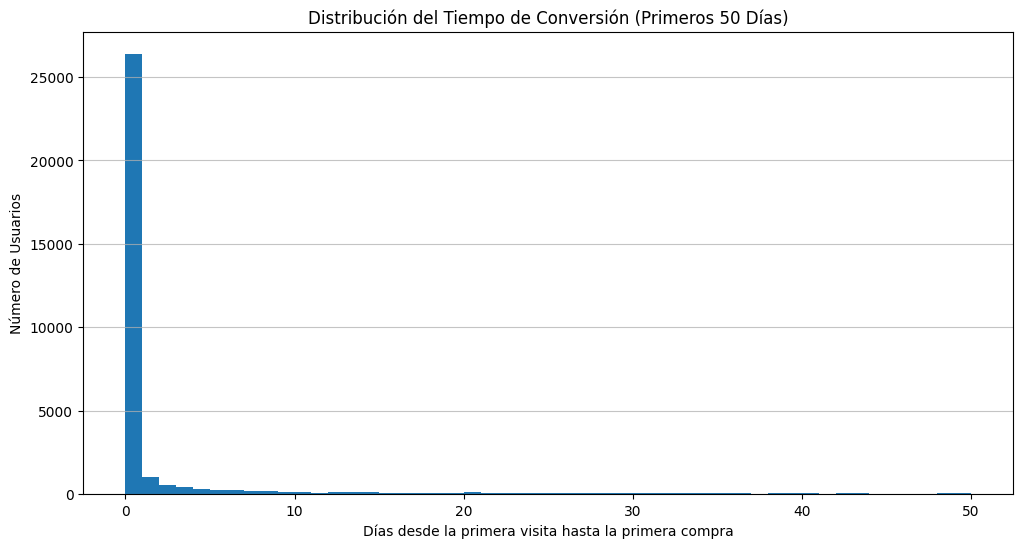

In [11]:
#buscamos la fecha de la primera sesión para cada usuario
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit_ts']

#encontramos la fecha de la primera compra por usuario
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_buy_ts']

# unimos tablas
conversion_data = pd.merge(first_visits, first_orders, on='uid')

# tiempo de conversión en días
conversion_data['conversion_days'] = (conversion_data['first_buy_ts'] - conversion_data['first_visit_ts']).dt.days

# sacamos los datos estadisticos necesarios 
avg_conversion_time = conversion_data['conversion_days'].mean()
median_conversion_time = conversion_data['conversion_days'].median()

print(f"El tiempo promedio de conversión es de: {avg_conversion_time:.1f} días.")
print(f"La mediana del tiempo de conversión es de: {median_conversion_time:.0f} día(s).")

#mostramos los gráficos para mostrar la distribución de compra de los usuarios
plt.figure(figsize=(12, 6))
plt.hist(conversion_data['conversion_days'], bins=50, range=(0, 50))
plt.title('Distribución del Tiempo de Conversión (Primeros 50 Días)')
plt.xlabel('Días desde la primera visita hasta la primera compra')
plt.ylabel('Número de Usuarios')
plt.grid(axis='y', alpha=0.75)
plt.show()

En la gráfica podemos ver que la gran mayoría de los clientes compran el mismo día de su primera visita, el histograma muestra una barra altísima en el día 0, lo cual indica que hay ofertas atractivas para los nuevos visitantes, la mediana es nuestro valor más representativo, la media es muy probable que esté influenciada por valores atípicos. si, co

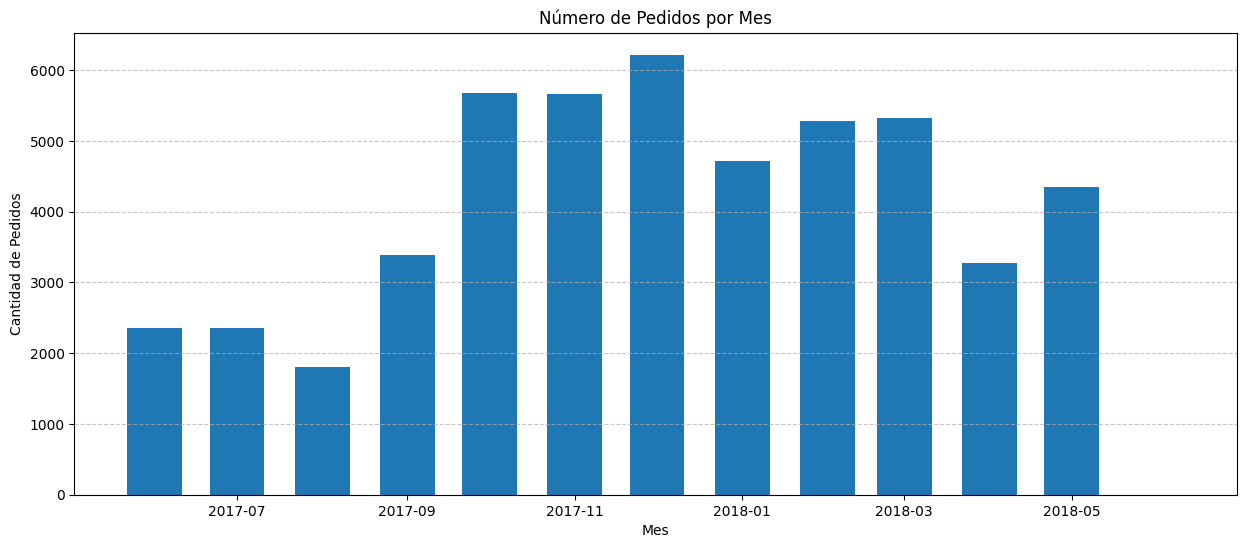

En promedio, se realizan 3878 pedidos al mes.


In [12]:
#cuantos pedidos se hacen durante el periodo de tiempo dado
#creamos una columna con el mes del pedido para agrupar
orders['order_month_dt'] = orders['buy_ts'].dt.to_period('M').dt.to_timestamp()

#agrupamos por mes y contar el número de pedidos
orders_per_month = orders.groupby('order_month_dt')['uid'].count().reset_index()
orders_per_month.columns = ['month', 'order_count']

#vemos los resultados
plt.figure(figsize=(15, 6))
plt.bar(orders_per_month['month'], orders_per_month['order_count'], width=20)
plt.title('Número de Pedidos por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Pedidos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#imprimimos resultados 
avg_orders_per_month = orders_per_month['order_count'].mean()
print(f"En promedio, se realizan {avg_orders_per_month:.0f} pedidos al mes.")

Podemos ver que la base de pedidos del año 2018 es consistentemente más alta que la del año anterior, lo cual es una buena señal ya que indica que el negocio está creciendo, vemos que incrementa mucho a finales del 2017, esto puede ser reflejo de estacionalidad, ya sea por black friday o navidad, para 2018 aún no tenemos esos datos para confirmar eso. Y vemos un promedio estable de 3878 pedidos al mes 

In [13]:
#cual es el tamaño promedio de compra.
#filtramos para incluir solo los pedidos con ingresos mayores a cero
paid_orders = orders[orders['revenue'] > 0]

# Calcular el AOV
average_order_value = paid_orders['revenue'].mean()

print(f"El tamaño promedio de la compra (AOV) es de: ${average_order_value:.2f}")

El tamaño promedio de la compra (AOV) es de: $5.00


con este dato podemos decir que si cuesta menos de $5 dolares traer a un cliente la compra ya es rentable.

In [14]:
#Calculo de LTV
#lo primero es preparar las cohortes, encontramos el mes de la primera compra de cada usuario para definir su cohorte
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['cohort_month'] = first_orders['first_order_ts'].dt.to_period('M')

#unimos la información de la cohorte a la tabla principal de pedidos
orders_with_cohorts = pd.merge(orders, first_orders[['uid', 'cohort_month']], on='uid')

#calculamos la edad de la cohorte para cada pedido
orders_with_cohorts['order_month'] = orders_with_cohorts['buy_ts'].dt.to_period('M')
orders_with_cohorts['cohort_lifetime'] = (orders_with_cohorts['order_month'].dt.year - orders_with_cohorts['cohort_month'].dt.year) * 12 + \
                                          (orders_with_cohorts['order_month'].dt.month - orders_with_cohorts['cohort_month'].dt.month)

print("Tabla de pedidos con la cohorte y la edad de cada pedido:")
print(orders_with_cohorts.head())

#calculamos el tamaño de cada cohorte (número de clientes únicos)
cohort_sizes = orders_with_cohorts.groupby('cohort_month')['uid'].nunique().reset_index()
cohort_sizes.columns = ['cohort_month', 'n_buyers']

print("\nNúmero de compradores en cada cohorte:")
print(cohort_sizes.head())


Tabla de pedidos con la cohorte y la edad de cada pedido:
               buy_ts  revenue                   uid order_month_dt  \
0 2017-06-01 00:10:00    17.00  10329302124590727494     2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447     2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844     2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005     2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450     2017-06-01   

  cohort_month order_month  cohort_lifetime  
0      2017-06     2017-06                0  
1      2017-06     2017-06                0  
2      2017-06     2017-06                0  
3      2017-06     2017-06                0  
4      2017-06     2017-06                0  

Número de compradores en cada cohorte:
  cohort_month  n_buyers
0      2017-06      2023
1      2017-07      1923
2      2017-08      1370
3      2017-09      2581
4      2017-10      4340


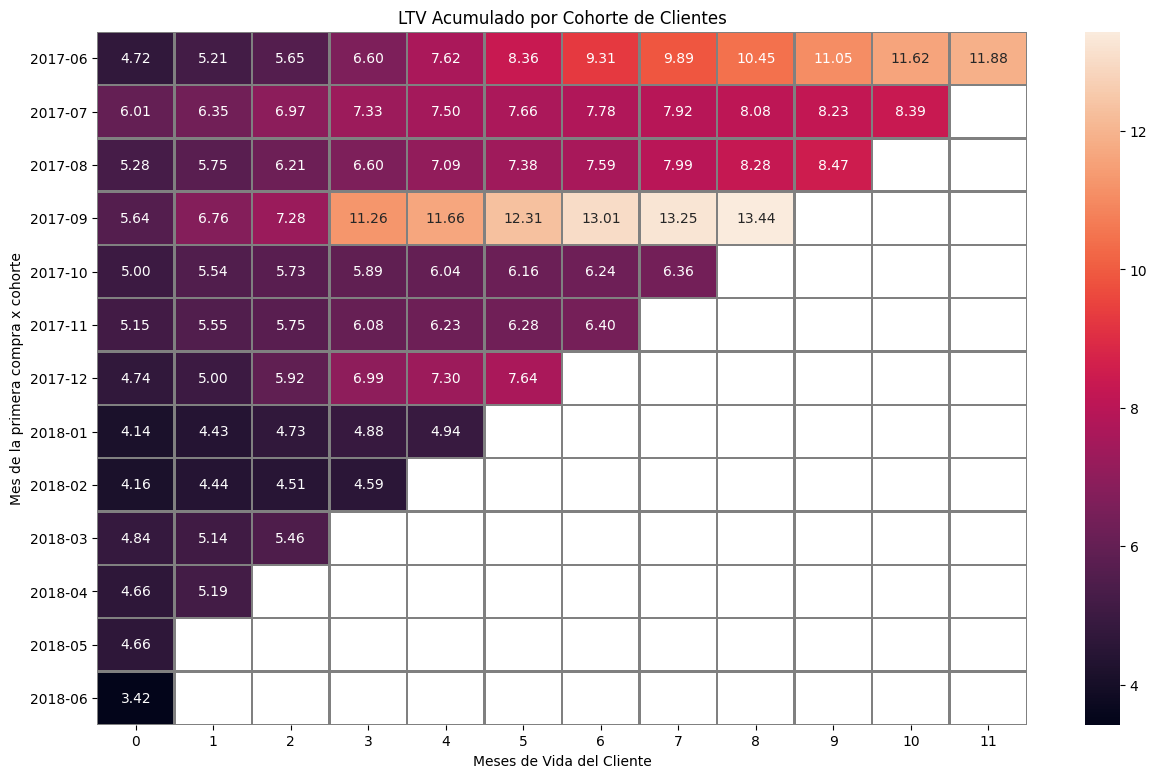

In [15]:
#calculo y visualización del ltv
#agrupamos por cohorte y edad para obtener los ingresos totales
cohort_data = orders_with_cohorts.groupby(['cohort_month', 'cohort_lifetime'])['revenue'].sum().reset_index()

#unimos los datos de ingresos con el tamaño de las cohortes
report = pd.merge(cohort_sizes, cohort_data, on='cohort_month')

#Calculamos el ltv mensual
report['ltv'] = report['revenue'] / report['n_buyers']

#creamos la tabla pivote para mostrar el mapa de calor
ltv_pivot = report.pivot_table(
    index='cohort_month',
    columns='cohort_lifetime',
    values='ltv',
    aggfunc='mean'
)

#calculamos el ltv acumulado, usamos cumsum(axis=1) para sumar los valores a lo largo de las columnas (meses de vida)
cumulative_ltv = ltv_pivot.cumsum(axis=1)

#generamos el mapa de calor 
plt.figure(figsize=(15, 9))
plt.title('LTV Acumulado por Cohorte de Clientes')
sns.heatmap(
    cumulative_ltv,
    annot=True,
    fmt='.2f',  # Formato para dos decimales
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Meses de Vida del Cliente')
plt.ylabel('Mes de la primera compra x cohorte')
plt.show()

En este gráfico podemos observar que el valor del cliente aumenta con el tiempo, ya que los clientes siguen comprando después de su primera compra, generando en promedio entre $7 y $9 en seis meses, sin grandes diferencias entre cohortes, lo que muestra una estrategia de adquisición estable, por eso, al evaluar los gastos de marketing, debe considerarse que el valor inicial de $5 por cliente puede más que duplicarse durante el primer año.

Sección 3 Marketing: 

In [16]:
#cuanto dinero se gastó
#gasto total
total_costs = costs['costs'].sum()
print(f"El gasto total en marketing fue de: ${total_costs:,.2f}")


#gasto por fuente
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index().sort_values(by='costs', ascending=False)
print("Gasto total por fuente de adquisición:")
print(costs_by_source)

El gasto total en marketing fue de: $329,131.62
Gasto total por fuente de adquisición:
   source_id      costs
2          3  141321.63
3          4   61073.60
4          5   51757.10
1          2   42806.04
0          1   20833.27
6         10    5822.49
5          9    5517.49


In [17]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


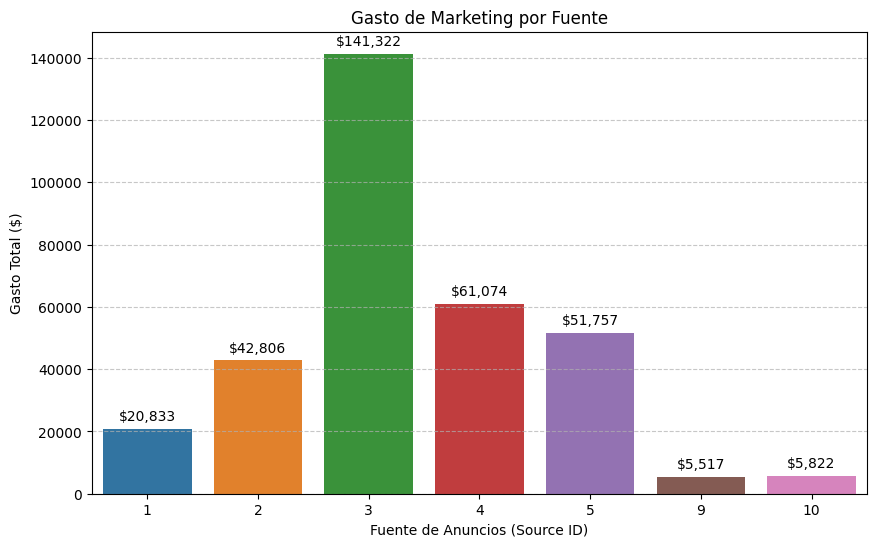

In [18]:
#generamos gráfico de gasto por fuente
plt.figure(figsize=(10, 6))
# Guardamos el gráfico en una variable 'ax' para poder manipularlo
ax = sns.barplot(x='source_id', y='costs', data=costs_by_source)
#añadimos etiquetas
for p in ax.patches:
    ax.annotate(f"${p.get_height():,.0f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
ax.set_title('Gasto de Marketing por Fuente')
ax.set_xlabel('Fuente de Anuncios (Source ID)')
ax.set_ylabel('Gasto Total ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El gasto en marketing está concentrado en pocas fuentes (la fuente 3 representa más del 40% del total), se ajusta bien a la temporada alta de ventas, pero aún no sabemos si es eficiente, por eso, es clave analizar el costo de adquisición de clientes (CAC) por canal para medir su rentabilidad.

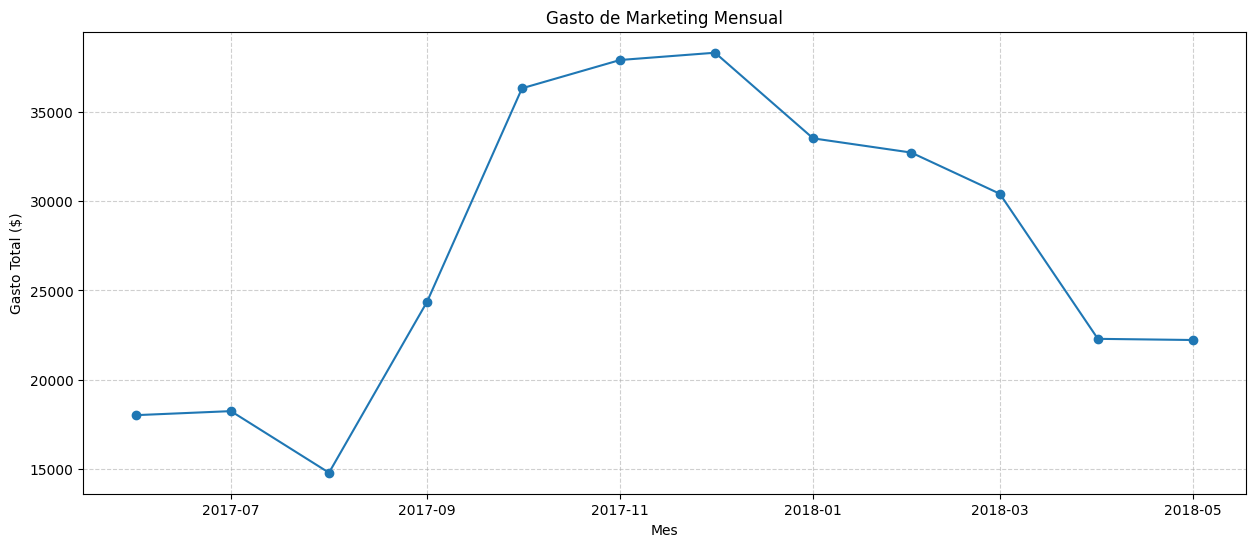

In [19]:
#gasto a lo largo del tiempo
costs_over_time = costs.groupby(costs['dt'].dt.to_period('M'))['costs'].sum()
costs_over_time_dt = costs_over_time.index.to_timestamp() 

#generamos el gráfico de gasto
plt.figure(figsize=(15, 6))
plt.plot(costs_over_time_dt, costs_over_time.values, marker='o', linestyle='-')
plt.title('Gasto de Marketing Mensual')
plt.xlabel('Mes')
plt.ylabel('Gasto Total ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

En la grafíca podemos ver que se invirtieron $329,131.62 en marketing, concentrándose principalmente en la fuente 3 (más de $141,000), seguida por las fuentes 4 y 5, mientras que las fuentes 9 y 10 recibieron muy poco presupuesto; además, el gasto creció a fin de año para aprovechar la temporada alta, lo que refleja una estrategia bien alineada, aunque sigue pendiente evaluar si esta distribución es realmente rentable al compararla con los clientes que generó cada fuente.

In [20]:
#encontramos la información completa de la primera visita de cada usuario
first_visit_indices = visits.groupby('uid')['start_ts'].idxmin()
first_visits_data = visits.loc[first_visit_indices]

#calculamos el número de clientes nuevos por mes y por fuente
first_visits_data['acquisition_month'] = first_visits_data['start_ts'].dt.to_period('M')
n_new_customers = first_visits_data.groupby(['acquisition_month', 'source_id'])['uid'].nunique().reset_index()
n_new_customers.columns = ['ad_month', 'source_id', 'n_customers']

#Calculamos los costos mensuales por fuente
costs['ad_month'] = costs['dt'].dt.to_period('M')
monthly_costs = costs.groupby(['ad_month', 'source_id'])['costs'].sum().reset_index()

#Unimos los costos con los clientes nuevos
report_cac_prep = pd.merge(monthly_costs, n_new_customers, on=['ad_month', 'source_id'])

print("Tabla de datos lista para el cálculo de CAC:")
print(report_cac_prep.head())

Tabla de datos lista para el cálculo de CAC:
  ad_month  source_id    costs  n_customers
0  2017-06          1  1125.61          631
1  2017-06          2  2427.38         1262
2  2017-06          3  7731.65         4080
3  2017-06          4  3514.80         3447
4  2017-06          5  2616.12         2728


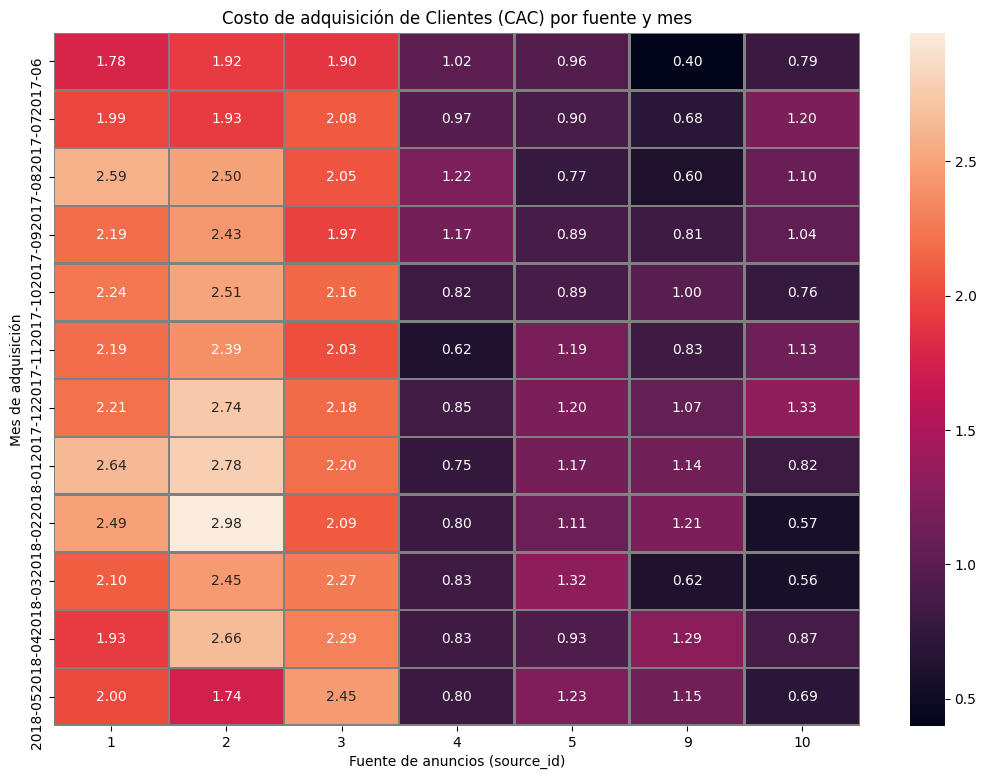

CAC promedio por fuente:
   source_id       cac
3          4  0.889874
5          9  0.900366
6         10  0.905963
4          5  1.047218
2          3  2.140098
0          1  2.196375
1          2  2.418852


In [21]:
#calculamos la columna de CAC
report_cac_prep['cac'] = report_cac_prep['costs'] / report_cac_prep['n_customers']

#creamos la tabla pivote para el heatmap
pivot_cac = report_cac_prep.pivot_table(index='ad_month', columns='source_id', values='cac')

#generamos el heatmap
plt.figure(figsize=(13, 9))
sns.heatmap(pivot_cac, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Costo de adquisición de Clientes (CAC) por fuente y mes')
plt.xlabel('Fuente de anuncios (source_id)')
plt.ylabel('Mes de adquisición')
plt.show()

#calculo de cac promedio por fuente
cac_avg_by_source = report_cac_prep.groupby('source_id')['cac'].mean().reset_index()

print("CAC promedio por fuente:")
print(cac_avg_by_source.sort_values(by='cac'))

El análisis del CAC revela grandes diferencias de eficiencia: la fuente 1 es la más rentable, con un costo de adquisición de solo $1.52 por cliente, mientras que la fuente 3 es la más cara con $4.76, aunque todos los canales siguen siendo rentables porque el valor promedio de compra ($5.00) supera el CAC. Sin embargo, dado que la mayor inversión se concentra en la fuente más costosa, hay una oportunidad clara de optimizar reasignando presupuesto hacia canales más eficientes como las fuentes 1, 2 y 5.

#Que tan rentables son las inversiones? (ROMI)
#definimos nuestro LTV de referencia a 6 meses (basado en el heatmap de LTV)
ltv_benchmark_6_months = 8.50

#copiamos la tabla de CAC para no modificar la original
romi_report = cac_avg_by_source

#calculamos el ROMI para cada fuente
romi_report['romi'] = (ltv_benchmark_6_months - romi_report['cac']) / romi_report['cac']

print(f"Cálculo de ROMI basado en un LTV de 6 meses de ${ltv_benchmark_6_months:.2f}")
print("ROMI por fuente de adquisición:")
print(romi_report.sort_values(by='romi', ascending=False))

El análisis de ROMI muestra que la fuente 1 es la más rentable, generando $4.58 por cada dólar invertido, seguida de las fuentes 2, 5, 9 y 10 con retornos superiores a 1.7. Por otra parte, la fuente 3 es la menos rentable, con un ROMI de 0.78, muy por debajo del resto pese a recuperar la inversión.

Conclusiones finales: 

Después de analizar el comportamiento de los usuarios, las ventas y los costos de marketing, queda claro que Showz tiene una base sólida: los usuarios permanecen en promedio 10 minutos en la plataforma y la mayoría compra rápido, con un ticket promedio de $5.00 que ya cubre el CAC de casi todos los canales. Además, el valor de cada cliente se duplica en los meses siguientes, lo que habla de buena retención y de un modelo de negocio sano. Sin embargo, hay una gran área de mejora, la mayor parte del presupuesto se está yendo a la fuente menos eficiente (fuente 3), que tiene el CAC más alto y el ROMI más bajo. La recomendación es clara: reducir inversión en esta fuente y redirigir ese dinero hacia la fuente 1, la más rentable con un CAC de solo $1.52 y un ROMI de 4.58, así como a las fuentes 2 y 5, que también demuestran buenos resultados.
